## Football Score Analysis

As a warm up we look at the Hong Kong Premier League, extracting some football match results and building a rough pipeline for the analysis.

In [8]:
%matplotlib inline

import requests
import pandas as pd
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/2015%E2%80%9316_Hong_Kong_Premier_League'

page = requests.get(url)
page
page.content

soup = BeautifulSoup(page.content, 'html.parser')

events_tables = [event.find_all('table') for event in soup.find_all('div', class_='vevent')]
table_columns = []
for i in range(0,10):
    events_items = [table[0].find_all('td')[i].get_text() for table in events_tables]
    table_columns.append(events_items)
table_columns

event_dates = table_columns[0]
event_home_teams = table_columns[1]
event_scores = table_columns[2]
event_away_teams = table_columns[3]
event_home_score = [int(stringEle.split(u'–')[0]) for stringEle in event_scores]
event_away_score = [int(stringEle.split(u'–')[1]) for stringEle in event_scores]
event_total_goals = [int(stringEle.split(u'–')[0]) + int(stringEle.split(u'–')[1]) for stringEle in event_scores]

In [9]:
events_results = pd.DataFrame({
    "date": event_dates,
    "home": event_home_teams,
    "scores": event_scores,
    "away": event_away_teams,
    "home_score": event_home_score,
    "away_score": event_away_score,
    "total_goals": event_total_goals
})
events_results = events_results[['date', 'home', 'home_score', 'scores', 'away', 'away_score', 'total_goals']]
print(events_results)

                              date                  home  home_score scores  \
0   12 September 2015 (2015-09-12)  Dreams Metro Gallery           2    2–0   
1   12 September 2015 (2015-09-12)               Kitchee           4    4–0   
2   13 September 2015 (2015-09-13)              Southern           3    3–3   
3   13 September 2015 (2015-09-13)               Rangers           1    1–2   
4   18 September 2015 (2015-09-18)               Rangers           1    1–1   
5   19 September 2015 (2015-09-19)  Dreams Metro Gallery           0    0–3   
6   19 September 2015 (2015-09-19)               Eastern           1    1–0   
7    23 December 2015 (2015-12-23)               Kitchee           4    4–2   
8   26 September 2015 (2015-09-26)           South China           1    1–0   
9   26 September 2015 (2015-09-26)               Eastern           1    1–1   
10  27 September 2015 (2015-09-27)  Dreams Metro Gallery           3    3–2   
11  27 September 2015 (2015-09-27)            HK Peg

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e7c94a8>]],
      dtype=object)

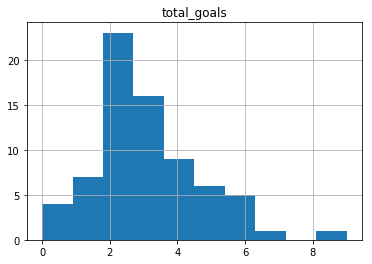

In [10]:
pd.DataFrame.hist(data=events_results, column=['total_goals'])

So our idea is that a Poisson distribution is what it takes to measure number of goals scored, number of goals taken and as a result determine things such as Over/Under and Asian Handicap probabilities.

The Poisson distribution has only one parameter $\mu$, corresponding to the mean value of the distribution. One parameter is pretty good since we do not have that much data to evaluate it in the first place, minimise the effect of overfitting:

$$ P(X=k) = \frac{\mu^k \exp{\mu}}{k\!!} $$

For the total goals we can compute the mean and fit a distribution against it.

In [19]:
import numpy as np

mu = np.mean(events_results['total_goals'])
print(mu)

mu_pd = events_results['total_goals'].mean()
print(mu_pd)

home_mean = events_results.groupby('home')[['home', 'home_score']].mean()
away_mean = events_results.groupby('away')[['away', 'away_score']].mean()
print(home_mean)
print(away_mean)

2.9583333333333335
2.9583333333333335
                      home_score
home                            
Dreams Metro Gallery       1.125
Eastern                    2.125
HK Pegasus                 0.750
Kitchee                    2.375
Rangers                    0.875
South China                1.500
Southern                   2.500
Wong Tai Sin               1.625
Yuen Long                  1.875
                      away_score
away                            
Biu Chun Rangers        3.000000
Dreams Metro Gallery    1.250000
Eastern                 2.250000
HK Pegasus              2.000000
Kitchee                 1.625000
Rangers                 0.714286
South China             1.750000
Southern                0.750000
Wong Tai Sin            0.500000
Yuen Long               0.750000


In [21]:
home = events_results[['home', 'home_score']]
home.columns = ['team', 'goals']
away = events_results[['away', 'away_score']]
away.columns = ['team', 'goals']

team_goals = pd.concat([home, away])
team_goals.groupby('team').mean()

,goals
team,
Biu Chun Rangers,3.0000
Dreams Metro Gallery,1.1875
Eastern,2.1875
HK Pegasus,1.3750
Kitchee,2.0000
Rangers,0.8000
South China,1.6250
Southern,1.6250
Wong Tai Sin,1.0625


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f08abe0>,
      dtype=object)

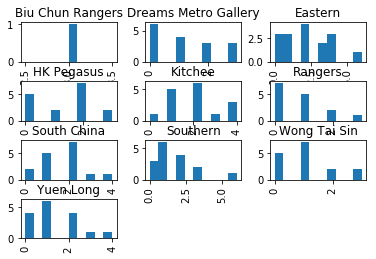

In [32]:
team_goals.loc[team_goals['team']=='Kitchee']

pd.DataFrame.hist(data=team_goals, column=['goals'], by=['team'])

The plan should be something simpler to start with:
* Collect the data of each event starting with the first season of the HK Premier League
* Prepare the data so that each team has for each match a number of goal scored and taken
* Assign for each team one Poisson distribution for number of goals scored and one for number of goals taken
* For each match get the total number of goals scored and fit a distribution on that